In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# movies = pd.read_csv('./data/tmdb_5000_movies.csv').head(n=1)
# credits = pd.read_csv('./data/tmdb_5000_credits.csv').head(n=1)
movies = pd.read_csv('./data/movies_train.csv')
credits = pd.read_csv('./data/credits_train.csv')

### Create list of all actors

In [3]:
%run -i clean-movies.py

In [4]:
unique_actors_count = pd.crosstab(actors, columns='count')

unique_actors_count \
.sort_values(by='count', ascending=False).head(12)

col_0,count
row_0,
Samuel L. Jackson - 2231,60
Robert De Niro - 380,51
Bruce Willis - 62,42
Morgan Freeman - 192,42
Matt Damon - 1892,40
John Goodman - 1230,39
Steve Buscemi - 884,39
Liam Neeson - 3896,38
Alec Baldwin - 7447,37


#### Total Number of unique actors

In [5]:
len(unique_actors_count)

51063

#### Total Number of actors that show up more than once

In [6]:
len(unique_actors_count[unique_actors_count.values > 1])

14214

#### Total Number of actors that show up more than three times

In [7]:
len(unique_actors_count[unique_actors_count.values > 3])

4727

In [8]:
sam_count = unique_actors_count[unique_actors_count.index == 'Samuel L. Jackson - 2231']
sam_count

col_0,count
row_0,
Samuel L. Jackson - 2231,60


In [9]:
sam_count.values[0][0]

60

### Create Actors Features

## Actor Vectorization

### label records as having Any Star (top 5 high performers)

In [10]:
stars = [
    get_actor_feature_name('2231'), # Samuel L. Jackson
    get_actor_feature_name('380'),  # Robert De Niro
    get_actor_feature_name('62'),   # Bruce Willis
    get_actor_feature_name('1892'), # Matt Damon
    get_actor_feature_name('192'),  # Morgan Freeman
]
movies['stars'] = actor_vector_works[stars].any(axis='columns')
movies_with_stars = movies[movies.stars == True]
len(movies_with_stars)

224

### label records as having Samuel L. Jackson

In [11]:
movies_with_samuel = movies[movies.samuel == True]

#### There should be 67 movies with Samuel L Jackson

In [12]:
len(movies_with_samuel)

60

In [13]:
baseline_prediction = len(movies_with_stars) / len(movies)
1 - baseline_prediction

0.9481721425266081

# Genres

In [14]:
movies.genres.head()

0    [{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...
1    [{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...
2    [{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...
3    [{'id': 53, 'name': 'Thriller'}, {'id': 878, '...
4    [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...
Name: genres, dtype: object

In [15]:
movies.genres[0][0]

{'id': 18, 'name': 'Drama'}

In [16]:
def unique_genres(movies_genres):
    genre_map = {}
    for genres in movies_genres:
        for genre in genres:
            name = genre['name']
            if not name in genre_map:
                genre_map[name] = 0
            genre_map[name]+=1
    return pd.Series(genre_map).sort_values(ascending=False)

### All Unique Genres

In [17]:
unique_genres(movies.genres)

Drama              2059
Comedy             1559
Thriller           1143
Action             1040
Romance             804
Adventure           706
Crime               628
Science Fiction     480
Horror              477
Family              467
Fantasy             375
Mystery             303
Animation           217
History             177
Music               169
War                 128
Documentary          97
Western              74
Foreign              30
TV Movie              8
dtype: int64

### Genres which Samuel is in

In [18]:
movies_merge = pd.merge(left=movies, right=actor_vector_works, left_on='id', right_on='id')
movies_with_samuel = movies_merge[movies_merge[get_actor_feature_name('2231')] == 1]
unique_genres(movies_with_samuel['genres'])

Action             32
Thriller           24
Drama              24
Crime              22
Adventure          19
Science Fiction    15
Comedy              9
Mystery             8
Romance             5
Animation           4
Family              4
Western             2
Horror              2
Music               2
Fantasy             2
Documentary         1
War                 1
dtype: int64

### Genres which Samuel is in

In [19]:
movies_with_stars = movies_merge[movies_merge[stars].any(axis='columns')]
unique_genres(movies_with_stars['genres'])

Drama              104
Thriller            92
Action              85
Crime               77
Comedy              61
Adventure           46
Science Fiction     33
Mystery             23
Family              21
Romance             20
Animation           15
Fantasy             11
War                  7
Horror               6
History              5
Western              4
Documentary          3
Music                3
dtype: int64

### Number of genres in movie

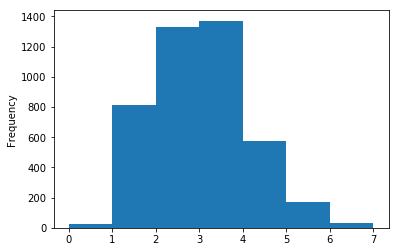

In [20]:
number_genres = movies.genres.apply(len)
number_genres.plot.hist(bins=np.max(number_genres))
plt.show()

## Genre Vectorization

In [21]:
def get_genres_feature_name(genre):
    return genre['name'] + ' (genre)'

In [22]:
movies_genres_ids = []
movie_genres_names_by_id = {}
for genres in movies.genres:
    movie_genres_ids = []
    for genre in genres:
        genre_feature_name = get_genres_feature_name(genre)
        movie_genres_ids.append(str(genre['id']))
        movie_genres_names_by_id[str(genre['id'])] = genre_feature_name
    movies_genres_ids.append(' '.join(movie_genres_ids))

In [23]:
genre_vectorization = CountVectorizer()

movie_vector = genre_vectorization.fit_transform(movies_genres_ids).toarray()
genre_feature_ids = genre_vectorization.get_feature_names()


In [24]:
def get_feature_names_by_ids(ids):
    genre_feature_names = []

    for id in ids:
        genre_feature_names.append(movie_genres_names_by_id[id])
    return genre_feature_names

genre_feature_names = get_feature_names_by_ids(genre_feature_ids)

In [25]:
genre_vector = pd.DataFrame(movie_vector, columns=genre_feature_names)
genre_vector['id'] = movies.id

### Normalize Movie Features

In [26]:
features_to_normalize = [
    'budget',
    'popularity',
    'vote_average',
    'vote_count',
    'revenue'
]

In [27]:
for feature in features_to_normalize:
    feature_array = movies[feature].values.astype('float64').reshape(1, -1)
    movies[feature + '_original'] =     movies[feature]
    movies[feature] = normalize(feature_array, axis=1, norm='max')[0]

In [28]:
movies[features_to_normalize].head(n=1)

,budget,popularity,vote_average,vote_count,revenue
0,0.033333,0.005877,0.51,0.006035,0.000006


# Create x/y

In [29]:
len(actor_vector_works)

4322

In [30]:
important_features = features_to_normalize + ['id']

movies_with_important_features = movies[important_features]
y = movies.samuel
x = pd.merge(left=movies_with_important_features, right=actor_vector_works, left_on='id', right_on='id')
len(x.columns)

4728

#### Merge in Genres

In [31]:
x = pd.merge(left=x, right=genre_vector, left_on='id', right_on='id')
len(x.columns)

4748

### Remove id as a feature

In [32]:
x = x[x.columns.difference(['id'])]
len(x.columns)

4747

### Remove "Stars" from actors

In [33]:
def remove_samuel(x):
    return x[x.columns.difference(stars)]
x = remove_samuel(x)
len(x.columns)

4742

### Create Cross-validation (10% holdout)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.1, random_state=3, stratify=y)

In [35]:
X_train.shape, y_train.shape

((3889, 4742), (3889,))

## Get Accuracy

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools

In [37]:
def show_confusion_matrix(y, predict_true, x):
    cm = confusion_matrix(y, predict_true)
    cm = pd.DataFrame(cm)
    cm.columns = ['Negative', 'Positive']
    cm.index = ['Negative', 'Positive']
    print(cm)
    
    return
    cmap=plt.cm.Blues
    classes = x.columns
    tick_marks = np.arange(len(classes))
    title = 'Confusion Matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [38]:
def get_accuracy(model, x, y):
    predict_true = np.zeros(len(y))
    if hasattr(model, 'predict_classes'):
        predict_true = model.predict_classes(x)
    elif hasattr(model, 'predict'):
        predict_true = model.predict(x)
    else:
        predict_true = model.fit_predict(x)
    print('Number of positive predictions {}'.format(len(predict_true[predict_true == True])))
    print('')
    print('Accuracy {}'.format(accuracy_score(y, predict_true)))
    print('')
    show_confusion_matrix(y, predict_true, x)

# Naive Bayes Classifications

In [39]:
bayes_model = MultinomialNB()
bayes_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
print('Accuracy of Training Data')
get_accuracy(bayes_model, X_train, y_train)

Accuracy of Training Data
Number of positive predictions 32

Accuracy 0.9912573926459244

          Negative  Positive
Negative      3829         6
Positive        28        26


In [41]:
print('Accuracy of Test Data')
get_accuracy(bayes_model, X_test, y_test)

Accuracy of Test Data
Number of positive predictions 5

Accuracy 0.9838337182448037

          Negative  Positive
Negative       424         3
Positive         4         2


# Deep Learning (Dense Layers)

In [42]:
from keras import models, layers

Using TensorFlow backend.


In [43]:
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(8, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(1, activation='sigmoid'))
model.add(layers.Dropout(.2))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 37944     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
__________

In [45]:
model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
3889/3889 [==============================] - 1s 245us/step - loss: 0.2865 - acc: 0.8465
Epoch 2/10
3889/3889 [==============================] - 1s 137us/step - loss: 0.0986 - acc: 0.9

In [46]:
get_accuracy(model, X_test, y_test)

Number of positive predictions 0

Accuracy 0.9861431870669746

          Negative  Positive
Negative       427         0
Positive         6         0


In [47]:
import time
model_file = 'data/movies_models/samuel_movies{}.h5'.format(time.time())
model.save(model_file)

### Hierarchical Clustering

In [48]:
#from sklearn.cluster import AgglomerativeClustering
#cluster_model = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='complete')
#cluster_model.fit(X_train, y_train)

In [49]:
#print('Accuracy of Training Data')
#get_accuracy(cluster_model, X_train, y_train)

In [50]:
#print('Accuracy of Test Data')
#get_accuracy(cluster_model, X_test, y_test)

# Shap

In [51]:
# import shap

In [52]:
# explainer = shap.KernelExplainer(model.predict_proba, X_train, link="logit")
# shap_values = explainer.shap_values(X_test, nsamples=100)


# Determine Feature Importance

In [53]:
np.random.seed(20)

In [54]:
random_forest = RandomForestClassifier()

In [55]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [56]:
features_names = x.columns
features_importance = random_forest.feature_importances_

In [57]:
feature_rank_df = pd.DataFrame({
    'features_importance': features_importance,
    'features_names': features_names,
}, index = features_names)

In [58]:
top_twenty_features = feature_rank_df \
    .sort_values(by=['features_importance'], ascending=False)[0:20] \
    .sort_values(by=['features_importance'])

### Top Ten Features

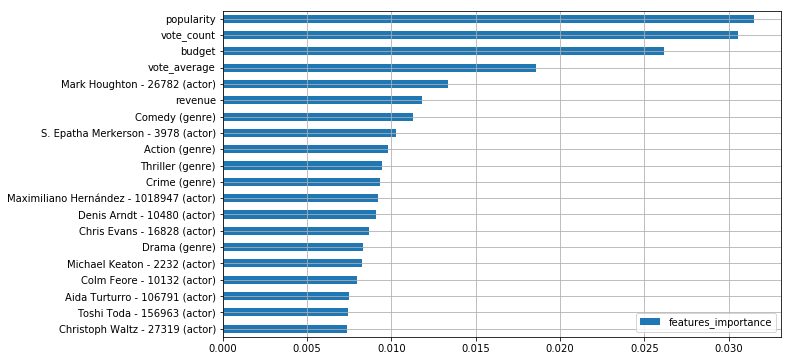

In [77]:
top_twenty_features.plot.barh(grid=True, figsize=(10, 6))
plt.show()

### Distribution of feature importance

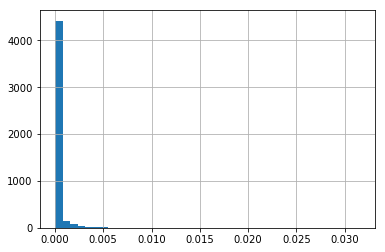

In [78]:
feature_rank_df.features_importance.hist(bins=40)
plt.show()

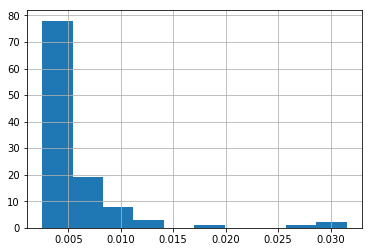

In [79]:
feature_rank_df[features_importance > 0.0025].features_importance.hist(bins=10)
plt.show()

### Number of useless features

In [62]:
useless_features = feature_rank_df.features_importance[feature_rank_df.features_importance == 0].size
total_features = feature_rank_df.size

print('{} out of {} features have no impact'.format(useless_features, total_features))

3876 out of 9484 features have no impact


# REGRESSION
Try to predict how much money a movie will make

In [63]:
movies.revenue_original.hist(bins = 40, figsize=(15, 10))

In [64]:
max_revenue = movies.revenue_original.max()
movies[movies.revenue_original == max_revenue]

,Unnamed: 0_x,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,title_y,cast,crew,samuel,budget_original,popularity_original,vote_average_original,vote_count_original,revenue_original,stars
654,0,0.79,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",0.171815,...,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",False,0.79,0.171815,0.72,0.858057,1.0,False


In [65]:
y_reg = x.revenue.values
x_reg = x[x.columns.difference(['revenue'])]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=.2, random_state=3)

In [66]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train_reg.shape[1],)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [67]:
model.fit(X_train_reg, y_train_reg, epochs=15, batch_size=64)

Epoch 1/15
3457/3457 [==============================] - 1s 274us/step - loss: 0.0023 - mean_absolute_error: 0.0272

In [68]:
mse, mae = model.evaluate(X_test_reg, y_test_reg)

865/865 [==============================] - 0s 172us/step


In [69]:
mae

0.018073828846776073

### We are off by this dollar amount (on average)

In [70]:
mae * max_revenue

0.018073828846776073

### Try to predict a few values

In [71]:
### Value in millions
np.round(model.predict(X_test_reg[0:10]) * max_revenue / 100000)

array([[-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.]])

In [72]:
test_predictions = model.predict(X_test_reg)

In [73]:
compare = pd.DataFrame({
    'test_predictions': test_predictions.flatten(),
    'test_actual': y_test_reg
})

### Success of prediction

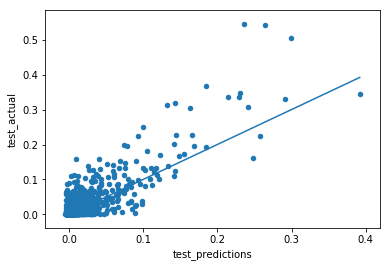

In [80]:
ax = compare.plot.scatter(x = 'test_predictions', y = 'test_actual')

_min = test_predictions.min()
_max = test_predictions.max()

ax.plot([_min, _max], [_min, _max])
plt.show()

In [75]:
# To save all movie_ids in a csv file
# movies.id.to_csv('data/movie_ids.csv', index=False)